In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/sample_submission.csv
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print("Доступные GPU: ", len(tf.config.list_physical_devices('GPU')))

2025-06-08 10:33:26.406756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749378806.682712      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749378806.760823      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Доступные GPU:  2


In [3]:
X = np.load(dirname + "/images.npy") # Данные для обучения
X = X / 255                          # Нормализуем
y = np.load(dirname + "/labels.npy") # Метки классов

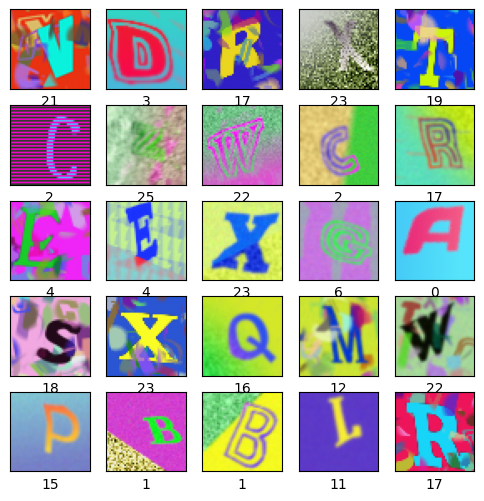

In [4]:
# Разбиваем данные на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Посмотрим примеры изображений
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

In [5]:
# Производим аугментацию наших изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [6]:
# Собираем модель
model = Sequential()

# I слой
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# II слой
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# III слой
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2)))

# Классификатор
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))
model.add(Dense(26, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1749378824.696257      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749378824.697003      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,469,338 (9.42 MB)

 Trainable params: 2,467,866 (9.41 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [7]:
# Обучаем на аугментированных данных
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30


I0000 00:00:1749378831.248196      64 service.cc:148] XLA service 0x7f8ac0006020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749378831.249350      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749378831.249372      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749378831.762703      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/250 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.0470 - loss: 4.0962

I0000 00:00:1749378837.151657      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.0493 - loss: 3.7416 - val_accuracy: 0.0380 - val_loss: 3.3782
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.1296 - loss: 3.0820 - val_accuracy: 0.2257 - val_loss: 2.6161
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.2890 - loss: 2.3626 - val_accuracy: 0.4103 - val_loss: 1.9263
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.3894 - loss: 1.9882 - val_accuracy: 0.5565 - val_loss: 1.4492
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4695 - loss: 1.7293 - val_accuracy: 0.6005 - val_loss: 1.3008
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4950 - loss: 1.6114 - val_accuracy: 0.6600 - val_loss: 1.1213
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5489 - loss: 1.4433 - val_accuracy: 0.7020 - val_loss: 0.9943
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.5736 - loss: 1.3639 - val_accurac

In [8]:
# Выводим метрики
val_loss, val_acc = model.evaluate(X_val, y_val)

print("Loss на валидационной выборке:", val_loss)
print("Accuracy на валидационной выборке:", val_acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8712 - loss: 0.3994
Loss на валидационной выборке: 0.4034798741340637
Accuracy на валидационной выборке: 0.8687499761581421


In [9]:
# Загружаем соревновательный датасет
sub_data = np.load(dirname + '/images_sub.npy') # Читаем
sub_data = sub_data / 255                       # Нормализуем
pred = np.argmax(
        model.predict(sub_data),
        axis=1
    )

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [10]:
# Сохраняем результат
submission = pd.DataFrame({
    "Id": range(len(pred)),
    "Category": pred
})

submission.to_csv("submission.csv", index=False)